## POS tagging using modified Viterbi - Jennis Marie Vicente-Feliciano

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
#nltk.download('universal_tagset')

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
#print some of the tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Build the vanilla Viterbi based POS tagger

In [5]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)
print(len(train_set))
print(len(test_set))

3718
196


In [6]:
print(train_set[:30])

[[('Wedtech', 'NOUN'), ("'s", 'PRT'), ('scammers', 'NOUN'), ('simply', 'ADV'), ('bribed', 'VERB'), ('them', 'PRON'), ('to', 'PRT'), ('shut', 'VERB'), ('up', 'ADP'), ('.', '.')], [('Why', 'ADV'), ('did', 'VERB'), ("n't", 'ADV'), ('you', 'PRON'), ('mention', 'VERB'), ('the', 'DET'), ('YMCA', 'NOUN'), ('or', 'CONJ'), ('the', 'DET'), ('YWCA', 'NOUN'), ('or', 'CONJ'), ('Catholic', 'NOUN'), ('Charities', 'NOUN'), ('USA', 'NOUN'), ('or', 'CONJ'), ('a', 'DET'), ('hundred', 'NUM'), ('other', 'ADJ'), ('nonprofit', 'ADJ'), ('organizations', 'NOUN'), ('that', 'DET'), ('*T*-17', 'X'), ('participated', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('march', 'NOUN'), ('*T*-1', 'X'), ('?', '.')], [('The', 'DET'), ('insurance', 'NOUN'), ('and', 'CONJ'), ('financial', 'ADJ'), ('services', 'NOUN'), ('concern', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('profit', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('quarter', 'NOUN'), ('rose', 'VERB'), ('1.1', 'NUM'), ('%', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('93.9', 'NUM')

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)
print(len(train_tagged_words))

95742


In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Wedtech',
 "'s",
 'scammers',
 'simply',
 'bribed',
 'them',
 'to',
 'shut',
 'up',
 '.']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12050


In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [11]:
print(T)

{'CONJ', 'X', 'NOUN', 'VERB', 'ADJ', 'NUM', 'ADV', '.', 'DET', 'PRT', 'PRON', 'ADP'}


In [12]:
android= [pair for pair in train_tagged_words if pair[0].lower() == 'android']
android

[]

### Emission Probabilities

In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# examples

# professor
print("\n", "professor")
print(word_given_tag('professor', 'ADJ'))
print(word_given_tag('professor', 'VERB'))
print(word_given_tag('professor', 'NOUN'), "\n")

# access
print("\n", "access")
print(word_given_tag('access', 'ADV'))
print(word_given_tag('access', 'NOUN'))
print(word_given_tag('access', 'VERB'))

# book
print("\n", "definitely")
print(word_given_tag('definitely', 'NOUN'))
print(word_given_tag('definitely', 'VERB'))


 professor
(0, 6073)
(0, 12923)
(8, 27484) 


 access
(0, 3013)
(8, 27484)
(0, 12923)

 definitely
(0, 27484)
(0, 12923)


### Transition Probabilities

In [16]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1(',', 'NOUN'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'NOUN'))

(4247, 6073)
(4247, 6073)
(5290, 8290)
(1426, 12923)
(0, 27484)
(21, 2623)
(4020, 27484)


In [18]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('NOUN', '.'))


(1931, 11147)
(1000, 11147)
(2469, 11147)
(2469, 11147)


In [19]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [20]:
tags_matrix

array([[4.65116289e-04, 7.44186062e-03, 3.52093011e-01, 1.56279072e-01,
        1.16279073e-01, 4.13953476e-02, 5.39534874e-02, 3.30232568e-02,
        1.23255812e-01, 4.65116277e-03, 5.81395365e-02, 5.30232564e-02],
       [9.99682676e-03, 7.47381747e-02, 6.22024760e-02, 2.05490321e-01,
        1.68200564e-02, 2.85623618e-03, 2.57061254e-02, 1.64392263e-01,
        5.55379242e-02, 1.84385911e-01, 5.58552854e-02, 1.42018408e-01],
       [4.25338373e-02, 2.92533841e-02, 2.65099704e-01, 1.46266922e-01,
        1.21161407e-02, 9.46004968e-03, 1.72100123e-02, 2.40430802e-01,
        1.31349145e-02, 4.36981507e-02, 4.65725502e-03, 1.76138848e-01],
       [5.26193622e-03, 2.18138203e-01, 1.10345893e-01, 1.68536723e-01,
        6.53099120e-02, 2.29822788e-02, 8.18695351e-02, 3.47442552e-02,
        1.34643659e-01, 3.11847087e-02, 3.60597372e-02, 9.09231603e-02],
       [1.63016636e-02, 2.12415606e-02, 6.99324906e-01, 1.23497443e-02,
        6.68532848e-02, 2.09122337e-02, 4.77523450e-03, 6.33

In [21]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [22]:
tags_df

,CONJ,X,NOUN,VERB,ADJ,NUM,ADV,.,DET,PRT,PRON,ADP
CONJ,0.000465,0.007442,0.352093,0.156279,0.116279,0.041395,0.053953,0.033023,0.123256,0.004651,0.058140,0.053023
X,0.009997,0.074738,0.062202,0.205490,0.016820,0.002856,0.025706,0.164392,0.055538,0.184386,0.055855,0.142018
NOUN,0.042534,0.029253,0.265100,0.146267,0.012116,0.009460,0.017210,0.240431,0.013135,0.043698,0.004657,0.176139
VERB,0.005262,0.218138,0.110346,0.168537,0.065310,0.022982,0.081870,0.034744,0.134644,0.031185,0.036060,0.090923
ADJ,0.016302,0.021242,0.699325,0.012350,0.066853,0.020912,0.004775,0.063395,0.005105,0.010703,0.000659,0.078380
NUM,0.013465,0.208259,0.356373,0.018851,0.033214,0.183124,0.002992,0.116098,0.003591,0.026631,0.001496,0.035907
ADV,0.006970,0.023565,0.032526,0.344175,0.129771,0.032194,0.078327,0.135413,0.068370,0.013940,0.015599,0.119150
.,0.058401,0.027362,0.221495,0.089710,0.044317,0.080291,0.052122,0.094106,0.173230,0.002512,0.066206,0.090159
DET,0.000483,0.046080,0.638118,0.039928,0.205187,0.022075,0.012425,0.016888,0.005549,0.000241,0.003619,0.009409
PRT,0.002294,0.014089,0.247379,0.403342,0.083879,0.055374,0.009830,0.043250,0.101573,0.001638,0.018021,0.019332


In [23]:
tags_df.loc['.', :]

CONJ    0.058401
X       0.027362
NOUN    0.221495
VERB    0.089710
ADJ     0.044317
NUM     0.080291
ADV     0.052122
.       0.094106
DET     0.173230
PRT     0.002512
PRON    0.066206
ADP     0.090159
Name: ., dtype: float32

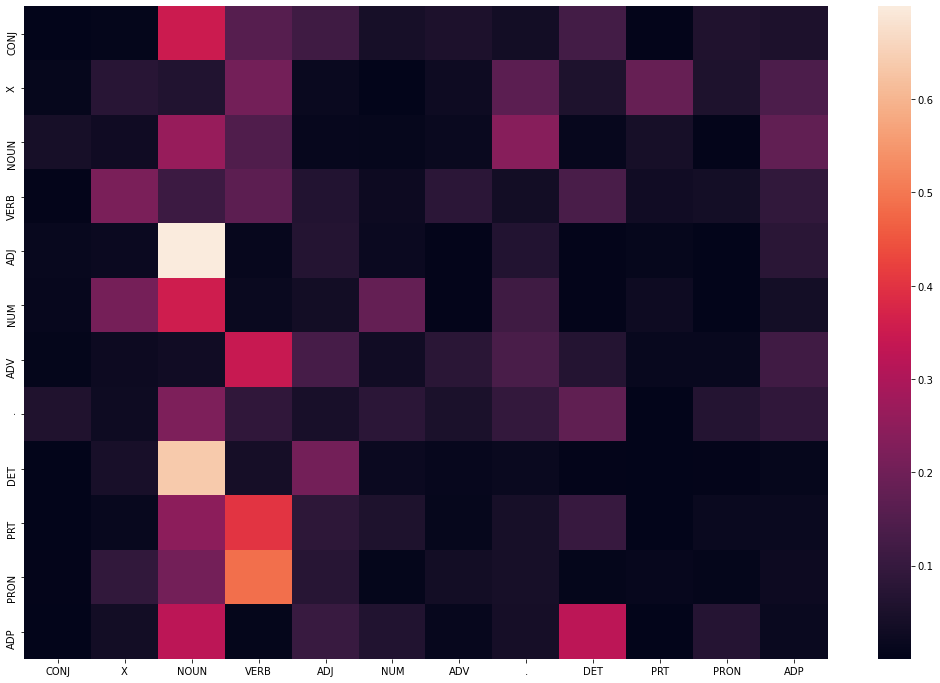

In [24]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


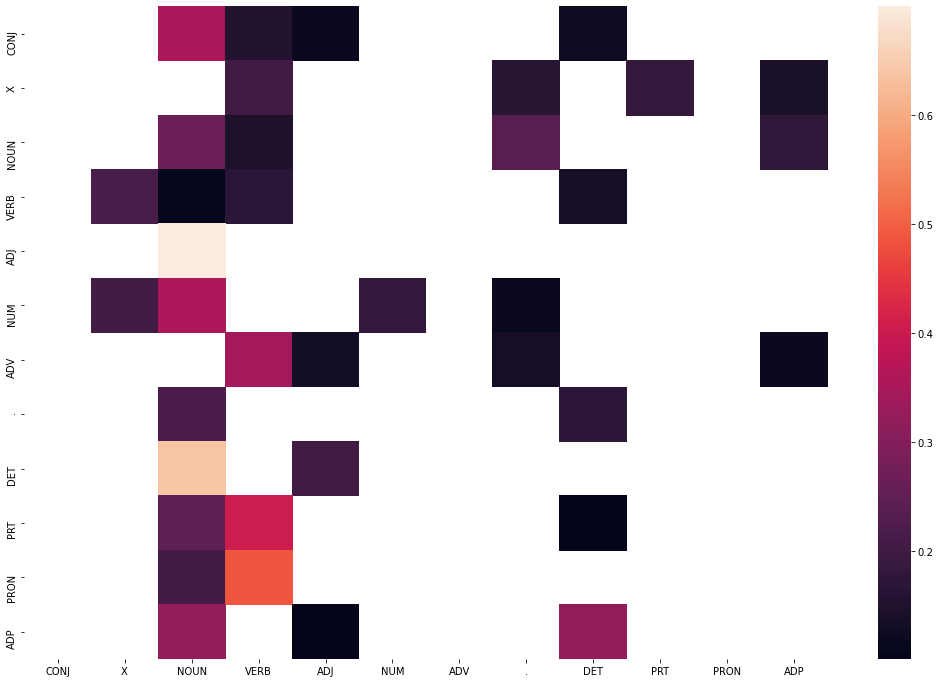

In [25]:
# frequent tags
# filter the df to get P(t2, t1) > 0.1
tags_frequent = tags_df[tags_df>0.1]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Virtebi Algorithm

In [26]:
len(train_tagged_words)

95742

In [27]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


### Evaluating the test set

In [28]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('In', 'ADP'),
  ('the', 'DET'),
  ('aftermath', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('stock', 'NOUN'),
  ('market', 'NOUN'),
  ("'s", 'PRT'),
  ('gut-wrenching', 'ADJ'),
  ('190-point', 'ADJ'),
  ('drop', 'NOUN'),
  ('on', 'ADP'),
  ('Oct.', 'NOUN'),
  ('13', 'NUM'),
  (',', '.'),
  ('Kidder', 'NOUN'),
  (',', '.'),
  ('Peabody', 'NOUN'),
  ('&', 'CONJ'),
  ('Co.', 'NOUN'),
  ("'s", 'PRT'),
  ('1,400', 'NUM'),
  ('stockbrokers', 'NOUN'),
  ('across', 'ADP'),
  ('the', 'DET'),
  ('country', 'NOUN'),
  ('began', 'VERB'),
  ('a', 'DET'),
  ('telephone', 'NOUN'),
  ('and', 'CONJ'),
  ('letter-writing', 'ADJ'),
  ('campaign', 'NOUN'),
  ('aimed', 'VERB'),
  ('*', 'X'),
  ('at', 'ADP'),
  ('*', 'X'),
  ('quashing', 'VERB'),
  ('the', 'DET'),
  ('country', 'NOUN'),
  ("'s", 'PRT'),
  ('second-largest', 'ADJ'),
  ('program', 'NOUN'),
  ('trader', 'NOUN'),
  ('.', '.')],
 [('In', 'ADP'),
  ('his', 'PRON'),
  ('ruling', 'NOUN'),
  (',', '.'),
  ('Judge', 'NOUN'),
  ('Curry', 'NOUN')

In [29]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [30]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  40.168633222579956
[('In', 'ADP'), ('the', 'DET'), ('aftermath', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ("'s", 'PRT'), ('gut-wrenching', 'CONJ'), ('190-point', 'CONJ'), ('drop', 'NOUN'), ('on', 'ADP'), ('Oct.', 'NOUN'), ('13', 'NUM'), (',', '.'), ('Kidder', 'NOUN'), (',', '.'), ('Peabody', 'NOUN'), ('&', 'CONJ'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('1,400', 'CONJ'), ('stockbrokers', 'NOUN'), ('across', 'ADP'), ('the', 'DET'), ('country', 'NOUN'), ('began', 'VERB'), ('a', 'DET'), ('telephone', 'NOUN'), ('and', 'CONJ'), ('letter-writing', 'CONJ'), ('campaign', 'NOUN'), ('aimed', 'VERB'), ('*', 'X'), ('at', 'ADP'), ('*', 'X'), ('quashing', 'CONJ'), ('the', 'DET'), ('country', 'NOUN'), ("'s", 'PRT'), ('second-largest', 'ADJ'), ('program', 'NOUN'), ('trader', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('his', 'PRON'), ('ruling', 'NOUN'), (',', '.'), ('Judge', 'NOUN'), ('Curry', 'NOUN'), ('added', 'VERB'), ('an', 'DET'), ('additional', 'A

In [31]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [32]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.864406779661017

In [33]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('gut-wrenching', 'CONJ'), ('gut-wrenching', 'ADJ'))],
 [('gut-wrenching', 'ADJ'), (('190-point', 'CONJ'), ('190-point', 'ADJ'))],
 [("'s", 'PRT'), (('1,400', 'CONJ'), ('1,400', 'NUM'))],
 [('and', 'CONJ'), (('letter-writing', 'CONJ'), ('letter-writing', 'ADJ'))],
 [('*', 'X'), (('quashing', 'CONJ'), ('quashing', 'VERB'))],
 [("'s", 'PRT'), (('calculations', 'CONJ'), ('calculations', 'NOUN'))],
 [('biggest', 'ADJ'), (('beneficiary', 'CONJ'), ('beneficiary', 'NOUN'))],
 [('which', 'DET'), (('*T*-118', 'CONJ'), ('*T*-118', 'X'))],
 [('well-known', 'ADJ'),
  (('detective-story', 'CONJ'), ('detective-story', 'NOUN'))],
 [(',', '.'), (('English', 'NOUN'), ('English', 'ADJ'))],
 [('English', 'ADJ'), (('novelist', 'CONJ'), ('novelist', 'NOUN'))],
 [('*T*-1', 'X'), (('finds', 'CONJ'), ('finds', 'VERB'))],
 [('its', 'PRON'), (('satisfaction', 'CONJ'), ('satisfaction', 'NOUN'))],
 [('in', 'ADP'), (('mathematical', 'CONJ'), ('mathematical', 'ADJ'))],
 [('mathematical', 'ADJ'),
 

In [34]:
#nltk.download('punkt')

In [78]:
## Testing
text = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(text)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [79]:
print(tagged_seq)
print(difference)

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.'), ('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'CONJ'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.'), ('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'CONJ'), ("'s", 'VERB'), ('firehose', 'CONJ'), ('.', '.'), ('Twitter', 'CONJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'CONJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'

### Solve the problem of unknown words

#### Regex Taggers 

In [37]:
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
regex_tagger = nltk.RegexpTagger(patterns)

#### Lexicon, Unigram Taggers Combined

In [38]:
#Combining taggers
default_tagger = nltk.DefaultTagger('NOUN')

In [39]:
unigram_tagger = nltk.UnigramTagger(train_set, backoff=default_tagger)

In [40]:
bigram_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger)

#### Evaluating tagging accuracy

In [41]:
regex_tagger.evaluate(test_set)

0.3640048642075395

In [42]:
unigram_tagger.evaluate(test_set)

0.9314957438184029

In [43]:
bigram_tagger.evaluate(test_set)

0.9341305229023105

#### Viterbi using the Bigram Tagger, backoff method.

In [44]:
#Viterbi using the Bigram Tagger, backoff method.
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = bigram_tagger.tag([word])[0][1]     
        if(pmax==0):
            state_max = bigram_tagger.tag([word])[0][1] 
        else:
            if state_max != 'X':
                 state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [45]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

In [46]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  35.8583779335022
[('In', 'ADP'), ('the', 'DET'), ('aftermath', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ("'s", 'PRT'), ('gut-wrenching', 'NOUN'), ('190-point', 'NOUN'), ('drop', 'NOUN'), ('on', 'ADP'), ('Oct.', 'NOUN'), ('13', 'NUM'), (',', '.'), ('Kidder', 'NOUN'), (',', '.'), ('Peabody', 'NOUN'), ('&', 'CONJ'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('1,400', 'NOUN'), ('stockbrokers', 'NOUN'), ('across', 'ADP'), ('the', 'DET'), ('country', 'NOUN'), ('began', 'VERB'), ('a', 'X'), ('telephone', 'NOUN'), ('and', 'CONJ'), ('letter-writing', 'NOUN'), ('campaign', 'NOUN'), ('aimed', 'VERB'), ('*', 'X'), ('at', 'ADP'), ('*', 'X'), ('quashing', 'NOUN'), ('the', 'DET'), ('country', 'NOUN'), ("'s", 'PRT'), ('second-largest', 'ADJ'), ('program', 'NOUN'), ('trader', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('his', 'PRON'), ('ruling', 'NOUN'), (',', '.'), ('Judge', 'NOUN'), ('Curry', 'NOUN'), ('added', 'VERB'), ('an', 'DET'), ('additional', 'ADJ')

In [47]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [48]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.8898305084745762

In [49]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('gut-wrenching', 'NOUN'), ('gut-wrenching', 'ADJ'))],
 [('gut-wrenching', 'ADJ'), (('190-point', 'NOUN'), ('190-point', 'ADJ'))],
 [("'s", 'PRT'), (('1,400', 'NOUN'), ('1,400', 'NUM'))],
 [('began', 'VERB'), (('a', 'X'), ('a', 'DET'))],
 [('and', 'CONJ'), (('letter-writing', 'NOUN'), ('letter-writing', 'ADJ'))],
 [('*', 'X'), (('quashing', 'NOUN'), ('quashing', 'VERB'))],
 [('which', 'DET'), (('*T*-118', 'NOUN'), ('*T*-118', 'X'))],
 [('November', 'NOUN'), (('1', 'X'), ('1', 'NUM'))],
 [('In', 'ADP'), (('a', 'X'), ('a', 'DET'))],
 [(',', '.'), (('English', 'NOUN'), ('English', 'ADJ'))],
 [('as', 'ADP'), (('a', 'X'), ('a', 'DET'))],
 [('*T*-1', 'X'), (('finds', 'NOUN'), ('finds', 'VERB'))],
 [('in', 'ADP'), (('mathematical', 'NOUN'), ('mathematical', 'ADJ'))]]

In [80]:
## Testing
text = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(text)

start = time.time()
tagged_seq = Viterbi_1(words)
end = time.time()
difference = end-start

In [81]:
print(tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'X'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'X'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('

#### Viterbi using the Unigram Tagger, backoff method.

In [52]:
#Viterbi using the Unigram Tagger, backoff method.
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = unigram_tagger.tag([word])[0][1]     
        if(pmax==0):
            state_max = unigram_tagger.tag([word])[0][1] 
        else:
            if state_max != 'X':
                 state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [53]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

In [54]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  33.450490951538086
[('In', 'ADP'), ('the', 'DET'), ('aftermath', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ("'s", 'PRT'), ('gut-wrenching', 'NOUN'), ('190-point', 'NOUN'), ('drop', 'NOUN'), ('on', 'ADP'), ('Oct.', 'NOUN'), ('13', 'NUM'), (',', '.'), ('Kidder', 'NOUN'), (',', '.'), ('Peabody', 'NOUN'), ('&', 'CONJ'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('1,400', 'NOUN'), ('stockbrokers', 'NOUN'), ('across', 'ADP'), ('the', 'DET'), ('country', 'NOUN'), ('began', 'VERB'), ('a', 'DET'), ('telephone', 'NOUN'), ('and', 'CONJ'), ('letter-writing', 'NOUN'), ('campaign', 'NOUN'), ('aimed', 'VERB'), ('*', 'X'), ('at', 'ADP'), ('*', 'X'), ('quashing', 'NOUN'), ('the', 'DET'), ('country', 'NOUN'), ("'s", 'PRT'), ('second-largest', 'ADJ'), ('program', 'NOUN'), ('trader', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('his', 'PRON'), ('ruling', 'NOUN'), (',', '.'), ('Judge', 'NOUN'), ('Curry', 'NOUN'), ('added', 'VERB'), ('an', 'DET'), ('additional', 'A

In [55]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [56]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.923728813559322

In [57]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('gut-wrenching', 'NOUN'), ('gut-wrenching', 'ADJ'))],
 [('gut-wrenching', 'ADJ'), (('190-point', 'NOUN'), ('190-point', 'ADJ'))],
 [("'s", 'PRT'), (('1,400', 'NOUN'), ('1,400', 'NUM'))],
 [('and', 'CONJ'), (('letter-writing', 'NOUN'), ('letter-writing', 'ADJ'))],
 [('*', 'X'), (('quashing', 'NOUN'), ('quashing', 'VERB'))],
 [('which', 'DET'), (('*T*-118', 'NOUN'), ('*T*-118', 'X'))],
 [(',', '.'), (('English', 'NOUN'), ('English', 'ADJ'))],
 [('*T*-1', 'X'), (('finds', 'NOUN'), ('finds', 'VERB'))],
 [('in', 'ADP'), (('mathematical', 'NOUN'), ('mathematical', 'ADJ'))]]

In [82]:
## Testing
text = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(text)

start = time.time()
tagged_seq = Viterbi_2(words)
end = time.time()
difference = end-start

In [83]:
print(tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

#### Viterbi using the Regex Tagger

In [60]:
#Viterbi using the Regex Tagger
def Viterbi_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = regex_tagger.tag([word])[0][1]     
        if(pmax==0):
            state_max = regex_tagger.tag([word])[0][1] 
        else:
            if state_max != 'X':
                 state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [61]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_3(test_tagged_words)
end = time.time()
difference = end-start

In [62]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  31.52274775505066
[('In', 'ADP'), ('the', 'DET'), ('aftermath', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ("'s", 'PRT'), ('gut-wrenching', 'VERB'), ('190-point', 'NOUN'), ('drop', 'NOUN'), ('on', 'ADP'), ('Oct.', 'NOUN'), ('13', 'NUM'), (',', '.'), ('Kidder', 'NOUN'), (',', '.'), ('Peabody', 'NOUN'), ('&', 'CONJ'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('1,400', 'NUM'), ('stockbrokers', 'NOUN'), ('across', 'ADP'), ('the', 'DET'), ('country', 'NOUN'), ('began', 'VERB'), ('a', 'DET'), ('telephone', 'NOUN'), ('and', 'CONJ'), ('letter-writing', 'VERB'), ('campaign', 'NOUN'), ('aimed', 'VERB'), ('*', 'X'), ('at', 'ADP'), ('*', 'X'), ('quashing', 'VERB'), ('the', 'DET'), ('country', 'NOUN'), ("'s", 'PRT'), ('second-largest', 'ADJ'), ('program', 'NOUN'), ('trader', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('his', 'PRON'), ('ruling', 'NOUN'), (',', '.'), ('Judge', 'NOUN'), ('Curry', 'NOUN'), ('added', 'VERB'), ('an', 'DET'), ('additional', 'ADJ

In [63]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [64]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9491525423728814

In [65]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('gut-wrenching', 'VERB'), ('gut-wrenching', 'ADJ'))],
 [('gut-wrenching', 'ADJ'), (('190-point', 'NOUN'), ('190-point', 'ADJ'))],
 [('and', 'CONJ'), (('letter-writing', 'VERB'), ('letter-writing', 'ADJ'))],
 [(',', '.'), (('English', 'NOUN'), ('English', 'ADJ'))],
 [('*T*-1', 'X'), (('finds', 'NOUN'), ('finds', 'VERB'))],
 [('in', 'ADP'), (('mathematical', 'NOUN'), ('mathematical', 'ADJ'))]]

In [84]:
## Testing
text = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(text)

start = time.time()
tagged_seq = Viterbi_3(words)
end = time.time()
difference = end-start

In [85]:
print(tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

The tagging accuracy of the Vanilla Viterbi algorithm is: 86.4%

The tagging accuracy of the Viterbi_1 algorithm is: 89.0%

The tagging accuracy of the Viterbi_2 algorithm is: 92.3%

The tagging accuracy of the Viterbi_3 algorithm is: 95.0%

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

('Android', 'CONJ') was incorrectly tagged by the Vanilla Viterbi tagger and was corrected by Bigram tagger. 

('domineering', 'CONJ') was incorrectly tagged by the Vanilla Viterbi tagger and corrected by the Regex tagger.

('arriving', 'CONJ') was incorrectly tagged by the Vanilla Viterbi but corrected by the Regex tagger.